In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()

True

In [4]:
llm = ChatOpenAI()

In [5]:
# State

class JokeState(TypedDict):

    topic: str
    joke: str
    explanation: str

In [6]:
def generate_joke(state: JokeState):

    prompt = f'generate a joke on the topic {state["topic"]}'
    response = llm.invoke(prompt).content

    return {'joke': response}

In [7]:
def generate_explanation(state: JokeState):

    prompt = f'write an explanation for the joke - {state["joke"]}'
    response = llm.invoke(prompt).content

    return {'explanation': response}

In [9]:
graph = StateGraph(JokeState)

# Nodes

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explanation', generate_explanation)

# Edges

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explanation')
graph.add_edge('generate_explanation', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

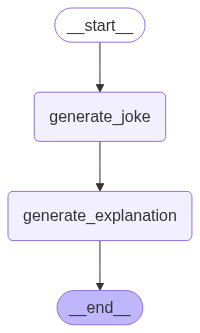

In [10]:
workflow

In [14]:
config1 = {"configurable": {"thread_id": "thread1"}}
initial_state = {'topic': 'Dhoni'}
workflow.invoke(input=initial_state, config=config1)

{'topic': 'Dhoni',
 'joke': 'Why did Dhoni bring a ladder to the cricket match? \nBecause he heard the highest runs are scored on top of the leaderboard!',
 'explanation': 'This joke plays on the idea of "scoring runs" in cricket, which is when a batsman hits the ball and runs between the wickets to accumulate points for their team. By bringing a ladder to the cricket match, Dhoni is humorously implying that he can reach the "top of the leaderboard," where the highest run scorers are ranked, by physically climbing to the top. It\'s a playful and clever way to reference Dhoni\'s skill and competitive spirit as a cricketer.'}

In [16]:
workflow.get_state(config=config1)

StateSnapshot(values={'topic': 'Dhoni', 'joke': 'Why did Dhoni bring a ladder to the cricket match? \nBecause he heard the highest runs are scored on top of the leaderboard!', 'explanation': 'This joke plays on the idea of "scoring runs" in cricket, which is when a batsman hits the ball and runs between the wickets to accumulate points for their team. By bringing a ladder to the cricket match, Dhoni is humorously implying that he can reach the "top of the leaderboard," where the highest run scorers are ranked, by physically climbing to the top. It\'s a playful and clever way to reference Dhoni\'s skill and competitive spirit as a cricketer.'}, next=(), config={'configurable': {'thread_id': 'thread1', 'checkpoint_ns': '', 'checkpoint_id': '1f07418c-89d1-65e2-8006-a479dc53634b'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-08-08T05:30:24.226002+00:00', parent_config={'configurable': {'thread_id': 'thread1', 'checkpoint_ns': '', 'checkpoint_id': '1f07418c-788b

In [15]:
list(workflow.get_state_history(config=config1))

[StateSnapshot(values={'topic': 'Dhoni', 'joke': 'Why did Dhoni bring a ladder to the cricket match? \nBecause he heard the highest runs are scored on top of the leaderboard!', 'explanation': 'This joke plays on the idea of "scoring runs" in cricket, which is when a batsman hits the ball and runs between the wickets to accumulate points for their team. By bringing a ladder to the cricket match, Dhoni is humorously implying that he can reach the "top of the leaderboard," where the highest run scorers are ranked, by physically climbing to the top. It\'s a playful and clever way to reference Dhoni\'s skill and competitive spirit as a cricketer.'}, next=(), config={'configurable': {'thread_id': 'thread1', 'checkpoint_ns': '', 'checkpoint_id': '1f07418c-89d1-65e2-8006-a479dc53634b'}}, metadata={'source': 'loop', 'step': 6, 'parents': {}}, created_at='2025-08-08T05:30:24.226002+00:00', parent_config={'configurable': {'thread_id': 'thread1', 'checkpoint_ns': '', 'checkpoint_id': '1f07418c-788

#### Time Travel

In [18]:
workflow.get_state({'configurable': {'thread_id': 'thread1', 'checkpoint_id': '1f07418c-788b-6117-8005-88a5e68793bb'}})

StateSnapshot(values={'topic': 'Dhoni', 'joke': 'Why did Dhoni bring a ladder to the cricket match? \nBecause he heard the highest runs are scored on top of the leaderboard!', 'explanation': "This joke is a play on Prime Minister Narendra Modi's desire to increase his power and influence in politics. By bringing a ladder to the election, it suggests that Modi is willing to go to great lengths to climb higher and attain even more power. The humor comes from the exaggerated idea of using a ladder to reach higher levels of power, when in reality, political power is gained through votes and support from the public."}, next=('generate_explanation',), config={'configurable': {'thread_id': 'thread1', 'checkpoint_id': '1f07418c-788b-6117-8005-88a5e68793bb'}}, metadata={'source': 'loop', 'step': 5, 'parents': {}}, created_at='2025-08-08T05:30:22.414626+00:00', parent_config={'configurable': {'thread_id': 'thread1', 'checkpoint_ns': '', 'checkpoint_id': '1f07418c-6bc0-6923-8004-ed2c1c145ecb'}}, 

#### Fault Tolerance

In [19]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [20]:
# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [21]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"step1": "done", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(1000)  # Simulate long-running hang
    return {"step2": "done"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Step 3 executed")
    return {"done": True}

In [22]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

new_checkpointer = InMemorySaver()
new_workflow = builder.compile(checkpointer=new_checkpointer)

In [30]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    new_workflow.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
❌ Kernel manually interrupted (crash simulated).


In [31]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = new_workflow.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)


🔁 Re-running the graph to demonstrate fault tolerance...
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)


KeyboardInterrupt: 